# Phase 1 Project - Business Recommendations for Microsoft


## Introduction
For this project, my team and I were tasked with providing business recommendations for Microsoft, a well-resourced company looking to join the film industry. Given the plethora of film studios and streaming services, we thought about what would make Microsoft stand out amongst its competitors. We also wanted to use Microsoft's key values to guide our investigation. Upon initial research, our team decided to hone in on Microsoft's focus on Diversity and Inclusion and its "transformative power of engaging many different perspectives". Our team branched out into different sectors of Diversity and Inclusion- looking at the successes of international films, movies featuring people of color, and the themes of different stories. 

This notebook in particular provides the research on the last decade's top grossing films and the actors and actresses featured in them. When looking at the data, I asked myself the following questions:
1. Does a film do better in the box office if it features people of color?
2. Are there more people of color in films now than before?
3. If so, are they casted for lead roles or do they play supporting characters?

## Scraping the Data

For my research, I scraped data from the-numbers.com to find the top-grossing actors from the last decade. Next, I scraped data from ethnicelebs.com to find each celebrity's ethnicity. For the sake of the project, I categorized ethnicities into racial categories defined by census.org. 

### 2010 Data

In [1]:
#Import necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
#Extract data from the-numbers.com to get highest-grossing stars for 2010 
url = 'https://www.the-numbers.com/box-office-star-records/worldwide/yearly-acting/highest-grossing-2010-stars'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

#Create list with actor's names for top-grossing stars
actor_container = soup.find('tbody')
actors = actor_container.findAll('a')
actors_names_2010 = [actor.text for actor in actor_container.findAll('a')]

#Creates list with actor's star scores 
star_score_2010 = []
for actor in soup.findAll('td', class_='data'):
    score = actor.nextSibling.nextSibling.nextSibling.nextSibling.text
    score = int(score)
    star_score_2010.append(score)
    
#Creates list with actor's billing average 
avg_billing_2010 = []
actors_billing_container = soup.findAll('td', align='right')
billing_avg = soup.findAll('td', align='right')[2::3]
for avg in billing_avg:
    billing = float(avg.text)
    avg_billing_2010.append(billing)

#Preview lists
print(actors_names_2010[:5])
print(star_score_2010[:5])
print(avg_billing_2010[:5])

['Robert Downey, Jr.', 'Taylor Lautner', 'Shia LaBeouf', 'Christian Bale', 'Robert Pattinson']
[410, 343, 309, 303, 281]
[1.4, 6.0, 2.8, 1.5, 1.8]


In [3]:
#To scrape data from ethnicelebs.com, we need to create a list with the following format
#ethnicelebs.com + /firstName-lastName
#Create a list of urls to by adding celeb name to ethnicelebs.com
url_names_2010 = []
for name in actors_names_2010:
    full_name = name.split(' ')
    url_name = '-'.join(full_name)
    ethniceleb_url = 'https://ethnicelebs.com/'+ str(url_name)
    url_names_2010.append(ethniceleb_url)

#From ethnicelebs.com, scrape the data for each celebrity's ethnicity.
#Create list of celeb ethnicity, filling 'NA' if page or ethnicity is not found
celeb_ethnicity_2010 = []
for url in url_names_2010:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    if soup.find('div', class_="entry-inner") != None:
        parent = soup.find('div', class_="entry-inner")
        if parent.find('strong') != None:
            ethnicity = parent.find('strong').text
            ethnicity = ethnicity[11:]
        else: 
            ethnicity = 'NA'
    else: 
        ethnicity = 'NA'
    celeb_ethnicity_2010.append(ethnicity)

In [20]:
#categorize ethnicities into Black, Asian, Native Hawaiian/Pacific Islander, Native American/Alaskan Native, or White  
racial_category_2010 = []
for ethnicity in celeb_ethnicity_2010:
    if 'Hawaiian' in ethnicity or 'Guamanian'in ethnicity or 'Samoan' in ethnicity or 'Pacific Island' in ethnicity:
        race_category = 'Native Hawaiin or Other Pacific Islander'
    elif 'African' in ethnicity or 'Zimbabwean' in ethnicity or 'Kenyan' in ethnicity or 'Nigerian' in ethnicity or 'Sierra Leonean' in ethnicity or 'Ghanian' in ethnicity or 'Ugandan' in ethnicity:
        race_category = 'Black'
    elif 'Chinese' in ethnicity or 'Filipino' in ethnicity or 'Korean' in ethnicity or 'Japanese' in ethnicity or 'Malaysian' in ethnicity or 'Taiwanese' in ethnicity:
        race_category = 'Asian'
    elif 'Mexican' in ethnicity or 'Puerto Rican' in ethnicity:
        race_category = 'American Indian or Alaska Native'
    else:
        race_category = 'White'
    racial_category_2010.append(race_category)

#Create a list of booleans that show whether actor is a person of color or not
poc_2010 = []
for rac_cat in racial_category_2010:
    poc_bool = (rac_cat != 'White')
    poc_2010.append(poc_bool)
    
#Fill in Year for later concatenation
year = ['2010'] * len(actors_names_2010)

#Create and preview DataFrame
celebdf_2010 = pd.DataFrame({'year':year, 'name': actors_names_2010, 'star_score': star_score_2010, 'avg_billing':avg_billing_2010, 'ethnicity': celeb_ethnicity_2010, 'racial_category': racial_category_2010, 'poc': poc_2010})
celebdf_2010.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
0,2010,"Robert Downey, Jr.",410,1.4,"Ashkenazi Jewish (three eighths), as well as E...",White,False
1,2010,Taylor Lautner,343,6.0,"Swiss-German, German, English, Dutch, Scottish...",White,False
2,2010,Shia LaBeouf,309,2.8,*Cajun/French (father)\n*Ashkenazi Jewish (mot...,White,False
3,2010,Christian Bale,303,1.5,"English, as well as distant Channel Islander [...",White,False
4,2010,Robert Pattinson,281,1.8,English,White,False


In [21]:
#Update Johnny Depp's racial category and POC status
#Johnny Depp classified as Black because his ethnicity string contains 'African', though his fraction for African is 3/2048.
#Because Johnny Depp has a high star score and there are so few Black actors to begin with, this throws off the star score mean tremendously.
celebdf_2010.at[9, 'racial_category'] = 'White'
celebdf_2010.at[9, 'poc'] = False

#preview info to make sure it's updated
celebdf_2010.iloc[[9]]

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
9,2010,Johnny Depp,259,2.5,"English, along with small amounts of Irish, Sc...",White,False


In [16]:
#Preview data on 2010's top-grossing actors's star_score and average billing
celebdf_2010.groupby(celebdf_2010['racial_category']).mean()

,star_score,avg_billing,poc
racial_category,,,
American Indian or Alaska Native,173.000000,3.600000,True
Asian,174.000000,1.900000,True
Black,133.800000,1.800000,True
White,172.857143,2.587912,False


In [17]:
#Preview data on the number of actors for each racial category
celebdf_2010.groupby(celebdf_2010['racial_category']).count()

,year,actors_names,star_score,avg_billing,ethnicity,poc
racial_category,,,,,,
American Indian or Alaska Native,2,2,2,2,2,2
Asian,2,2,2,2,2,2
Black,5,5,5,5,5,5
White,91,91,91,91,91,91


### 2011 Data

In [18]:
#Extract data from the-numbers.com to get highest-grossing stars for 2011 
url = 'https://www.the-numbers.com/box-office-star-records/worldwide/yearly-acting/highest-grossing-2011-stars'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

#Creates list with actor's names 
actor_container = soup.find('tbody')
actors = actor_container.findAll('a')
actors_names_2011 = [actor.text for actor in actor_container.findAll('a')]

#Creates list with actor's star scores 
star_score_2011 = []
for actor in soup.findAll('td', class_='data'):
    score = actor.nextSibling.nextSibling.nextSibling.nextSibling.text
    score = int(score)
    star_score_2011.append(score)
    
#Creates list with actor's billing average 
avg_billing_2011 = []
actors_billing_container = soup.findAll('td', align='right')
billing_avg = soup.findAll('td', align='right')[2::3]
for avg in billing_avg:
    billing = float(avg.text)
    avg_billing_2011.append(billing)

#Preview lists
print(actors_names_2011[:5])
print(star_score_2011[:5])
print(avg_billing_2011[:5])

['Bradley Cooper', 'Taylor Lautner', 'Johnny Depp', 'Robert Downey, Jr.', 'Robert Pattinson']
[428, 373, 357, 341, 326]
[2.5, 5.0, 2.2, 1.0, 1.8]


In [19]:
#Create a list of urls by adding celeb name to ethnicelebs.com
url_names_2011 = []
for name in actors_names_2011:
    full_name = name.split(' ')
    url_name = '-'.join(full_name)
    ethniceleb_url = 'https://ethnicelebs.com/'+ str(url_name)
    url_names_2011.append(ethniceleb_url)

#Create list of celeb ethnicity, filling 'NA' if page not found
celeb_ethnicity_2011 = []
for url in url_names_2011:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    if soup.find('div', class_="entry-inner") != None:
        parent = soup.find('div', class_="entry-inner")
        if parent.find('strong') != None:
            ethnicity = parent.find('strong').text
            ethnicity = ethnicity[11:]
        else: 
            ethnicity = 'NA'
    else: 
        ethnicity = 'NA'
    celeb_ethnicity_2011.append(ethnicity)
    
#categorize ethnicities into Black or African American, White, Asian     
racial_category_2011 = []
for ethnicity in celeb_ethnicity_2011:
    if 'Hawaiian' in ethnicity or 'Guamanian'in ethnicity or 'Samoan' in ethnicity or 'Pacific Island' in ethnicity:
        race_category = 'Native Hawaiin or Other Pacific Islander'
    elif 'African' in ethnicity or 'Zimbabwean' in ethnicity or 'Kenyan' in ethnicity or 'Nigerian' in ethnicity or 'Sierra Leonean' in ethnicity or 'Ghanian' in ethnicity or 'Ugandan' in ethnicity:
        race_category = 'Black'
    elif 'Chinese' in ethnicity or 'Filipino' in ethnicity or 'Korean' in ethnicity or 'Japanese' in ethnicity or 'Malaysian' in ethnicity or 'Taiwanese' in ethnicity:
        race_category = 'Asian'
    elif 'Mexican' in ethnicity or 'Puerto Rican' in ethnicity:
        race_category = 'American Indian or Alaska Native'
    else:
        race_category = 'White'
    racial_category_2011.append(race_category)

#Create a list of booleans that show whether actor is a person of color or not
poc_2011 = []
for rac_cat in racial_category_2010:
    poc_bool = (rac_cat != 'White')
    poc_2011.append(poc_bool)
    
#Fill in Year 
year = ['2011'] * len(actors_names_2011)

celebdf_2011 = pd.DataFrame({'year': year, 'name': actors_names_2011, 'star_score': star_score_2011, 'avg_billing': avg_billing_2011, 'ethnicity': celeb_ethnicity_2011, 'racial_category': racial_category_2011, 'poc': poc_2011})
celebdf_2011.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
0,2011,Bradley Cooper,428,2.5,*Irish (father)\n*Italian (mother),White,False
1,2011,Taylor Lautner,373,5.0,"Swiss-German, German, English, Dutch, Scottish...",White,False
2,2011,Johnny Depp,357,2.2,"English, along with small amounts of Irish, Sc...",Black,False
3,2011,"Robert Downey, Jr.",341,1.0,"Ashkenazi Jewish (three eighths), as well as E...",White,False
4,2011,Robert Pattinson,326,1.8,English,White,False


In [251]:
#Update Johnny Depp's racial category and poc status
celebdf_2011.at[2, 'racial_category'] = 'White'
celebdf_2011.at[2, 'poc'] = False

In [24]:
#Preview data on top-grossing actors's star_score and average billing
celebdf_2011.groupby(celebdf_2011['racial_category']).mean()

,star_score,avg_billing,poc
racial_category,,,
American Indian or Alaska Native,158.000000,17.000000,0.000000
Black,145.833333,3.250000,0.000000
Native Hawaiin or Other Pacific Islander,136.000000,2.000000,0.000000
White,182.688889,3.026667,0.111111


In [25]:
#Preview data on the number of actors for each racial category
celebdf_2011.groupby(celebdf_2011['racial_category']).count()

,year,name,star_score,avg_billing,ethnicity,poc
racial_category,,,,,,
American Indian or Alaska Native,3,3,3,3,3,3
Black,6,6,6,6,6,6
Native Hawaiin or Other Pacific Islander,1,1,1,1,1,1
White,90,90,90,90,90,90


### 2012 Data

In [26]:
#Extract data from the-numbers.com to get highest-grossing stars for 2010 
url = 'https://www.the-numbers.com/box-office-star-records/worldwide/yearly-acting/highest-grossing-2012-stars'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

#Creates list with actor's names 
actor_container = soup.find('tbody')
actors = actor_container.findAll('a')
actors_names_2012 = [actor.text for actor in actor_container.findAll('a')]

#Creates list with actor's star scores 
star_score_2012 = []
for actor in soup.findAll('td', class_='data'):
    score = actor.nextSibling.nextSibling.nextSibling.nextSibling.text
    score = int(score)
    star_score_2012.append(score)
    
#Creates list with actor's billing average 
avg_billing_2012 = []
actors_billing_container = soup.findAll('td', align='right')
billing_avg = soup.findAll('td', align='right')[2::3]
for avg in billing_avg:
    billing = float(avg.text)
    avg_billing_2012.append(billing)

#Preview lists
print(actors_names_2012[:5])
print(star_score_2012[:5])
print(avg_billing_2012[:5])

['Taylor Lautner', 'Kristen Stewart', 'Robert Downey, Jr.', 'Liam Neeson', 'Johnny Depp']
[374, 368, 348, 346, 341]
[5.0, 1.0, 1.0, 2.2, 1.0]


In [27]:
#Create a list of urls by adding celeb name to ethnicelebs.com
url_names_2012 = []
for name in actors_names_2012:
    full_name = name.split(' ')
    url_name = '-'.join(full_name)
    ethniceleb_url = 'https://ethnicelebs.com/'+ str(url_name)
    url_names_2012.append(ethniceleb_url)

#Create list of celeb ethnicity, filling 'NA' if page not found
celeb_ethnicity_2012 = []
for url in url_names_2012:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    if soup.find('div', class_="entry-inner") != None:
        parent = soup.find('div', class_="entry-inner")
        if parent.find('strong') != None:
            ethnicity = parent.find('strong').text
            ethnicity = ethnicity[11:]
        else: 
            ethnicity = 'NA'
    else: 
        ethnicity = 'NA'
    celeb_ethnicity_2012.append(ethnicity)
    
#categorize ethnicities into Black or African American, White, Asian     
racial_category_2012 = []
for ethnicity in celeb_ethnicity_2012:
    if 'Hawaiian' in ethnicity or 'Guamanian'in ethnicity or 'Samoan' in ethnicity or 'Pacific Island' in ethnicity:
        race_category = 'Native Hawaiin or Other Pacific Islander'
    elif 'African' in ethnicity or 'Zimbabwean' in ethnicity or 'Kenyan' in ethnicity or 'Nigerian' in ethnicity or 'Sierra Leonean' in ethnicity or 'Ghanian' in ethnicity or 'Ugandan' in ethnicity:
        race_category = 'Black'
    elif 'Chinese' in ethnicity or 'Filipino' in ethnicity or 'Korean' in ethnicity or 'Japanese' in ethnicity or 'Malaysian' in ethnicity or 'Taiwanese' in ethnicity or 'Indian' in ethnicity:
        race_category = 'Asian'
    elif 'Mexican' in ethnicity or 'Puerto Rican' in ethnicity:
        race_category = 'American Indian or Alaska Native'
    else:
        race_category = 'White'
    racial_category_2012.append(race_category)

#Create a list of booleans that show whether actor is a person of color or not
poc_2012 = []
for rac_cat in racial_category_2012:
    poc_bool = (rac_cat != 'White')
    poc_2012.append(poc_bool)
    
#Fill in Year for later concatenation
year = ['2012'] * len(actors_names_2012)

celebdf_2012 = pd.DataFrame({'year': year, 'name': actors_names_2012, 'star_score': star_score_2012, 'avg_billing':avg_billing_2012, 'ethnicity': celeb_ethnicity_2012, 'racial_category': racial_category_2012, 'poc': poc_2012})
celebdf_2012.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
0,2012,Taylor Lautner,374,5.0,"Swiss-German, German, English, Dutch, Scottish...",White,False
1,2012,Kristen Stewart,368,1.0,"possibly Scottish, English",White,False
2,2012,"Robert Downey, Jr.",348,1.0,"Ashkenazi Jewish (three eighths), as well as E...",White,False
3,2012,Liam Neeson,346,2.2,Irish,White,False
4,2012,Johnny Depp,341,1.0,"English, along with small amounts of Irish, Sc...",Black,True


In [28]:
#Update Johnny Depp's racial category and poc status
celebdf_2012.at[4, 'racial_category'] = 'White'
celebdf_2012.at[4, 'poc'] = False

#Update Jeremy Renner's racial category and poc status
celebdf_2012.at[7, 'racial_category'] = 'White'
celebdf_2012.at[7, 'poc'] = False

In [29]:
#Preview data on top-grossing actors's star_score and average billing
celebdf_2012.groupby(celebdf_2012['racial_category']).mean()

,star_score,avg_billing,poc
racial_category,,,
American Indian or Alaska Native,137.500000,23.850000,True
Asian,153.250000,2.200000,True
Black,157.250000,4.000000,True
Native Hawaiin or Other Pacific Islander,214.000000,1.700000,True
White,187.359551,3.057303,False


In [30]:
#Preview data on the number of actors for each racial category
celebdf_2012.groupby(celebdf_2012['racial_category']).count()

,year,name,star_score,avg_billing,ethnicity,poc
racial_category,,,,,,
American Indian or Alaska Native,2,2,2,2,2,2
Asian,4,4,4,4,4,4
Black,4,4,4,4,4,4
Native Hawaiin or Other Pacific Islander,1,1,1,1,1,1
White,89,89,89,89,89,89


### 2013 Data

In [31]:
#Extract data from the-numbers.com to get highest-grossing stars for 2013
url = 'https://www.the-numbers.com/box-office-star-records/worldwide/yearly-acting/highest-grossing-2013-stars'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

#Creates list with actor's names 
actor_container = soup.find('tbody')
actors = actor_container.findAll('a')
actors_names_2013 = [actor.text for actor in actor_container.findAll('a')]

#Creates list with actor's star scores 
star_score_2013 = []
for actor in soup.findAll('td', class_='data'):
    score = actor.nextSibling.nextSibling.nextSibling.nextSibling.text
    score = int(score)
    star_score_2013.append(score)
    
#Creates list with actor's billing average 
avg_billing_2013 = []
actors_billing_container = soup.findAll('td', align='right')
billing_avg = soup.findAll('td', align='right')[2::3]
for avg in billing_avg:
    billing = float(avg.text)
    avg_billing_2013.append(billing)

#Preview lists
print(actors_names_2013[:5])
print(star_score_2013[:5])
print(avg_billing_2013[:5])

['Jennifer Lawrence', 'Jeremy Renner', 'Chris Hemsworth', 'Bradley Cooper', 'Dwayne Johnson']
[407, 401, 395, 365, 365]
[2.4, 3.2, 2.0, 1.4, 2.4]


In [32]:
#Create a list of urls by adding celeb name to ethnicelebs.com
url_names_2013 = []
for name in actors_names_2013:
    full_name = name.split(' ')
    url_name = '-'.join(full_name)
    ethniceleb_url = 'https://ethnicelebs.com/'+ str(url_name)
    url_names_2013.append(ethniceleb_url)

#Create list of celeb ethnicity, filling 'NA' if page not found
celeb_ethnicity_2013 = []
for url in url_names_2013:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    if soup.find('div', class_="entry-inner") != None:
        parent = soup.find('div', class_="entry-inner")
        if parent.find('strong') != None:
            ethnicity = parent.find('strong').text
            ethnicity = ethnicity[11:]
        else: 
            ethnicity = 'NA'
    else: 
        ethnicity = 'NA'
    celeb_ethnicity_2013.append(ethnicity)
    
#categorize ethnicities into Black, Asian, Native Hawaiian/Pacific Islander, American Indian/Alaskan Native
racial_category_2013 = []
for ethnicity in celeb_ethnicity_2013:
    if 'Hawaiian' in ethnicity or 'Guamanian'in ethnicity or 'Samoan' in ethnicity or 'Pacific Island' in ethnicity:
        race_category = 'Native Hawaiin or Other Pacific Islander'
    elif 'African' in ethnicity or 'Zimbabwean' in ethnicity or 'Kenyan' in ethnicity or 'Nigerian' in ethnicity or 'Sierra Leonean' in ethnicity or 'Ghanian' in ethnicity or 'Ugandan' in ethnicity:
        race_category = 'Black'
    elif 'Chinese' in ethnicity or 'Filipino' in ethnicity or 'Korean' in ethnicity or 'Japanese' in ethnicity or 'Malaysian' in ethnicity or 'Taiwanese' in ethnicity or 'Indian' in ethnicity:
        race_category = 'Asian'
    elif 'Mexican' in ethnicity or 'Puerto Rican' in ethnicity:
        race_category = 'American Indian or Alaska Native'
    else:
        race_category = 'White'
    racial_category_2013.append(race_category)

#Create a list of booleans that show whether actor is a person of color or not
poc_2013 = []
for rac_cat in racial_category_2013:
    poc_bool = (rac_cat != 'White')
    poc_2013.append(poc_bool)
    
#Fill in Year for later concatenation
year = ['2013'] * len(actors_names_2013)
    
#Create DataFrame with 2013 information
celebdf_2013 = pd.DataFrame({'year': year, 'name': actors_names_2013, 'star_score': star_score_2013, 'avg_billing': avg_billing_2013, 'ethnicity': celeb_ethnicity_2013, 'racial_category': racial_category_2013, 'poc': poc_2013})
celebdf_2013.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
0,2013,Jennifer Lawrence,407,2.4,"English, German, Irish, Scottish, Scots-Irish/...",White,False
1,2013,Jeremy Renner,401,3.2,"Panamanian/Jamaican/African-Caribbean, German,...",Black,True
2,2013,Chris Hemsworth,395,2.0,"Dutch (maternal grandfather), Irish, English, ...",White,False
3,2013,Bradley Cooper,365,1.4,*Irish (father)\n*Italian (mother),White,False
4,2013,Dwayne Johnson,365,2.4,"*father – African-Canadian/Black Nova Scotian,...",Native Hawaiin or Other Pacific Islander,True


In [34]:
#Update Jeremy Renner's racial category and poc status
celebdf_2013.at[1, 'racial_category'] = 'White'
celebdf_2013.at[1, 'poc'] = False

#Update Johnny Depp's racial category and poc status
celebdf_2013.at[18, 'racial_category'] = 'White'
celebdf_2013.at[18, 'poc'] = False

In [35]:
#Preview data on top-grossing actors's star_score and average billing
celebdf_2013.groupby(celebdf_2013['racial_category']).mean()

,star_score,avg_billing,poc
racial_category,,,
American Indian or Alaska Native,167.000000,2.00,True
Asian,164.666667,4.50,True
Black,174.800000,2.79,True
Native Hawaiin or Other Pacific Islander,365.000000,2.40,True
White,187.564706,2.58,False


In [36]:
#Preview data on the number of actors for each racial category
celebdf_2013.groupby(celebdf_2013['racial_category']).count()

,year,name,star_score,avg_billing,ethnicity,poc
racial_category,,,,,,
American Indian or Alaska Native,1,1,1,1,1,1
Asian,3,3,3,3,3,3
Black,10,10,10,10,10,10
Native Hawaiin or Other Pacific Islander,1,1,1,1,1,1
White,85,85,85,85,85,85


### 2014 Data

In [37]:
#Extract data from the-numbers.com to get highest-grossing stars for 2013
url = 'https://www.the-numbers.com/box-office-star-records/worldwide/yearly-acting/highest-grossing-2014-stars'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

#Creates list with actor's names 
actor_container = soup.find('tbody')
actors = actor_container.findAll('a')
actors_names_2014 = [actor.text for actor in actor_container.findAll('a')]

#Creates list with actor's star scores 
star_score_2014 = []
for actor in soup.findAll('td', class_='data'):
    score = actor.nextSibling.nextSibling.nextSibling.nextSibling.text
    score = int(score)
    star_score_2014.append(score)
    
#Creates list with actor's billing average 
avg_billing_2014 = []
actors_billing_container = soup.findAll('td', align='right')
billing_avg = soup.findAll('td', align='right')[2::3]
for avg in billing_avg:
    billing = float(avg.text)
    avg_billing_2014.append(billing)

#Preview lists
print(actors_names_2014[:5])
print(star_score_2014[:5])
print(avg_billing_2014[:5])

['Jennifer Lawrence', 'Channing Tatum', 'Dwayne Johnson', 'Liam Neeson', 'Chris Hemsworth']
[516, 398, 337, 323, 309]
[2.5, 1.8, 2.0, 3.2, 2.2]


In [38]:
url_names_2014 = []
for name in actors_names_2014:
    full_name = name.split(' ')
    url_name = '-'.join(full_name)
    ethniceleb_url = 'https://ethnicelebs.com/'+ str(url_name)
    url_names_2014.append(ethniceleb_url)

#Create list of celeb ethnicity, filling 'NA' if page not found
celeb_ethnicity_2014 = []
for url in url_names_2014:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    if soup.find('div', class_="entry-inner") != None:
        parent = soup.find('div', class_="entry-inner")
        if parent.find('strong') != None:
            ethnicity = parent.find('strong').text
            ethnicity = ethnicity[11:]
        else: 
            ethnicity = 'NA'
    else: 
        ethnicity = 'NA'
    celeb_ethnicity_2014.append(ethnicity)
    
#categorize ethnicities into Black or African American, White, Asian     
racial_category_2014 = []
for ethnicity in celeb_ethnicity_2014:
    if 'Hawaiian' in ethnicity or 'Guamanian'in ethnicity or 'Samoan' in ethnicity or 'Pacific Island' in ethnicity:
        race_category = 'Native Hawaiin or Other Pacific Islander'
    elif 'African' in ethnicity or 'Zimbabwean' in ethnicity or 'Kenyan' in ethnicity or 'Nigerian' in ethnicity or 'Sierra Leonean' in ethnicity or 'Ghanian' in ethnicity or 'Ugandan' in ethnicity:
        race_category = 'Black'
    elif 'Chinese' in ethnicity or 'Filipino' in ethnicity or 'Korean' in ethnicity or 'Japanese' in ethnicity or 'Malaysian' in ethnicity or 'Taiwanese' in ethnicity or 'Indian' in ethnicity:
        race_category = 'Asian'
    elif 'Mexican' in ethnicity or 'Puerto Rican' in ethnicity:
        race_category = 'American Indian or Alaska Native'
    else:
        race_category = 'White'
    racial_category_2014.append(race_category)

#Create a list of booleans that show whether actor is a person of color or not
poc_2014 = []
for rac_cat in racial_category_2014:
    poc_bool = (rac_cat != 'White')
    poc_2014.append(poc_bool)
    
#Fill in Year for later concatenation
year = ['2014'] * len(actors_names_2014)
    
#Create DataFrame with 2013 information
celebdf_2014 = pd.DataFrame({'year': year, 'name': actors_names_2014, 'star_score': star_score_2014, 'avg_billing': avg_billing_2014, 'ethnicity': celeb_ethnicity_2014, 'racial_category': racial_category_2014, 'poc': poc_2014})
celebdf_2014.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
0,2014,Jennifer Lawrence,516,2.5,"English, German, Irish, Scottish, Scots-Irish/...",White,False
1,2014,Channing Tatum,398,1.8,"English, some Scots-Irish/Northern Irish and I...",White,False
2,2014,Dwayne Johnson,337,2.0,"*father – African-Canadian/Black Nova Scotian,...",Native Hawaiin or Other Pacific Islander,True
3,2014,Liam Neeson,323,3.2,Irish,White,False
4,2014,Chris Hemsworth,309,2.2,"Dutch (maternal grandfather), Irish, English, ...",White,False


In [39]:
#Update Jeremy Renner's racial category and poc status
celebdf_2014.at[6, 'racial_category'] = 'White'
celebdf_2014.at[6, 'poc'] = False

#Update Johnny Depp's racial category and poc status
celebdf_2014.at[34, 'racial_category'] = 'White'
celebdf_2014.at[34, 'poc'] = False

In [44]:
#Preview data on top-grossing actors's star_score and average billing
celebdf_2014.groupby(celebdf_2014['racial_category']).mean()

,star_score,avg_billing,poc
racial_category,,,
American Indian or Alaska Native,185.000000,4.500000,True
Asian,151.000000,4.375000,True
Black,179.700000,3.140000,True
Native Hawaiin or Other Pacific Islander,337.000000,2.000000,True
White,164.011905,2.540476,False


In [45]:
#Preview data on the number of actors for each racial category
celebdf_2014.groupby(celebdf_2014['racial_category']).count()

,year,name,star_score,avg_billing,ethnicity,poc
racial_category,,,,,,
American Indian or Alaska Native,1,1,1,1,1,1
Asian,4,4,4,4,4,4
Black,10,10,10,10,10,10
Native Hawaiin or Other Pacific Islander,1,1,1,1,1,1
White,84,84,84,84,84,84


### 2015 Data

In [42]:
#Extract data from the-numbers.com to get highest-grossing stars for 2015
url = 'https://www.the-numbers.com/box-office-star-records/worldwide/yearly-acting/highest-grossing-2015-stars'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

#Creates list with actor's names 
actor_container = soup.find('tbody')
actors = actor_container.findAll('a')
actors_names_2015 = [actor.text for actor in actor_container.findAll('a')]

#Creates list with actor's star scores 
star_score_2015 = []
for actor in soup.findAll('td', class_='data'):
    score = actor.nextSibling.nextSibling.nextSibling.nextSibling.text
    score = int(score)
    star_score_2015.append(score)
    
#Creates list with actor's billing average 
avg_billing_2015 = []
actors_billing_container = soup.findAll('td', align='right')
billing_avg = soup.findAll('td', align='right')[2::3]
for avg in billing_avg:
    billing = float(avg.text)
    avg_billing_2015.append(billing)

#Preview lists
print(actors_names_2015[:5])
print(star_score_2015[:5])
print(avg_billing_2015[:5])

['Jennifer Lawrence', 'Dwayne Johnson', 'Samuel L. Jackson', 'Channing Tatum', 'Hugh Jackman']
[475, 344, 324, 321, 301]
[2.3, 2.0, 5.3, 1.6, 1.4]


In [52]:
#Create list of urls for each celebrity 
url_names_2015 = []
for name in actors_names_2015:
    full_name = name.split(' ')
    url_name = '-'.join(full_name)
    ethniceleb_url = 'https://ethnicelebs.com/'+ str(url_name)
    url_names_2015.append(ethniceleb_url)

#Create list of celeb ethnicity, filling 'NA' if page not found
celeb_ethnicity_2015 = []
for url in url_names_2015:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    if soup.find('div', class_="entry-inner") != None:
        parent = soup.find('div', class_="entry-inner")
        if parent.find('strong') != None:
            ethnicity = parent.find('strong').text
            ethnicity = ethnicity[11:]
        else: 
            ethnicity = 'NA'
    else: 
        ethnicity = 'NA'
    celeb_ethnicity_2015.append(ethnicity)
    
#categorize ethnicities into Black or African American, White, Asian     
racial_category_2015 = []
for ethnicity in celeb_ethnicity_2015:
    if 'Hawaiian' in ethnicity or 'Guamanian'in ethnicity or 'Samoan' in ethnicity or 'Pacific Island' in ethnicity:
        race_category = 'Native Hawaiin or Other Pacific Islander'
    elif 'African' in ethnicity or 'Zimbabwean' in ethnicity or 'Kenyan' in ethnicity or 'Nigerian' in ethnicity or 'Sierra Leonean' in ethnicity or 'Ghanian' in ethnicity or 'Ugandan' in ethnicity:
        race_category = 'Black'
    elif 'Chinese' in ethnicity or 'Filipino' in ethnicity or 'Korean' in ethnicity or 'Japanese' in ethnicity or 'Malaysian' in ethnicity or 'Taiwanese' in ethnicity or 'Indian' in ethnicity:
        race_category = 'Asian'
    elif 'Mexican' in ethnicity or 'Puerto Rican' in ethnicity:
        race_category = 'American Indian or Alaska Native'
    else:
        race_category = 'White'
    racial_category_2015.append(race_category)

#Create a list of booleans that show whether actor is a person of color or not
poc_2015 = []
for rac_cat in racial_category_2015:
    poc_bool = (rac_cat != 'White')
    poc_2015.append(poc_bool)

#Fill in Year for later concatenation
year = ['2015'] * len(actors_names_2015)
    
#Create DataFrame with 2015 information
celebdf_2015 = pd.DataFrame({'year': year, 'name': actors_names_2015, 'star_score': star_score_2015, 'avg_billing': avg_billing_2015, 'ethnicity': celeb_ethnicity_2015, 'racial_category': racial_category_2015, 'poc': poc_2015})
celebdf_2015.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
0,2015,Jennifer Lawrence,475,2.3,"English, German, Irish, Scottish, Scots-Irish/...",White,False
1,2015,Dwayne Johnson,344,2.0,"*father – African-Canadian/Black Nova Scotian,...",Native Hawaiin or Other Pacific Islander,True
2,2015,Samuel L. Jackson,324,5.3,"African-American, likely some English",Black,True
3,2015,Channing Tatum,321,1.6,"English, some Scots-Irish/Northern Irish and I...",White,False
4,2015,Hugh Jackman,301,1.4,*62.5% English\n*25% Scottish\n*12.5% Greek,White,False


In [48]:
#Update Jeremy Renner's racial category and poc status
celebdf_2015.at[13, 'racial_category'] = 'White'
celebdf_2015.at[13, 'poc'] = False

#Update Johnny Depp's racial category and poc status
celebdf_2015.at[75, 'racial_category'] = 'White'
celebdf_2015.at[75, 'poc'] = False

In [49]:
#Preview data on top-grossing actors's star_score and average billing
celebdf_2015.groupby(celebdf_2015['racial_category']).mean()

,star_score,avg_billing,poc
racial_category,,,
American Indian or Alaska Native,185.000000,4.500000,True
Asian,176.500000,5.900000,True
Black,173.363636,2.890909,True
Native Hawaiin or Other Pacific Islander,344.000000,2.000000,True
White,162.847059,2.508235,False


In [50]:
#Preview data on the number of actors for each racial category
celebdf_2015.groupby(celebdf_2015['racial_category']).count()

,year,name,star_score,avg_billing,ethnicity,poc
racial_category,,,,,,
American Indian or Alaska Native,1,1,1,1,1,1
Asian,2,2,2,2,2,2
Black,11,11,11,11,11,11
Native Hawaiin or Other Pacific Islander,1,1,1,1,1,1
White,85,85,85,85,85,85


### 2016 Data

In [53]:
#Extract data from the-numbers.com to get highest-grossing stars for 2016
url = 'https://www.the-numbers.com/box-office-star-records/worldwide/yearly-acting/highest-grossing-2016-stars'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

#Creates list with actor's names 
actor_container = soup.find('tbody')
actors = actor_container.findAll('a')
actors_names_2016 = [actor.text for actor in actor_container.findAll('a')]

#Creates list with actor's star scores 
star_score_2016 = []
for actor in soup.findAll('td', class_='data'):
    score = actor.nextSibling.nextSibling.nextSibling.nextSibling.text
    score = int(score)
    star_score_2016.append(score)
    
#Creates list with actor's billing average 
avg_billing_2016 = []
actors_billing_container = soup.findAll('td', align='right')
billing_avg = soup.findAll('td', align='right')[2::3]
for avg in billing_avg:
    billing = float(avg.text)
    avg_billing_2016.append(billing)

#Preview lists
print(actors_names_2016[:5])
print(star_score_2016[:5])
print(avg_billing_2016[:5])

['Jennifer Lawrence', 'Samuel L. Jackson', 'Scarlett Johansson', 'Chris Pratt', 'Matt Damon']
[466, 392, 374, 311, 299]
[2.0, 6.0, 2.8, 1.5, 1.3]


In [54]:
url_names_2016 = []
for name in actors_names_2016:
    full_name = name.split(' ')
    url_name = '-'.join(full_name)
    ethniceleb_url = 'https://ethnicelebs.com/'+ str(url_name)
    url_names_2016.append(ethniceleb_url)

#Create list of celeb ethnicity, filling 'NA' if page not found
celeb_ethnicity_2016 = []
for url in url_names_2016:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    if soup.find('div', class_="entry-inner") != None:
        parent = soup.find('div', class_="entry-inner")
        if parent.find('strong') != None:
            ethnicity = parent.find('strong').text
            ethnicity = ethnicity[11:]
        else: 
            ethnicity = 'NA'
    else: 
        ethnicity = 'NA'
    celeb_ethnicity_2016.append(ethnicity)
    
#categorize ethnicities into Black or African American, White, Asian     
racial_category_2016 = []
for ethnicity in celeb_ethnicity_2016:
    if 'Hawaiian' in ethnicity or 'Guamanian'in ethnicity or 'Samoan' in ethnicity or 'Pacific Island' in ethnicity:
        race_category = 'Native Hawaiin or Other Pacific Islander'
    elif 'African' in ethnicity or 'Zimbabwean' in ethnicity or 'Kenyan' in ethnicity or 'Nigerian' in ethnicity or 'Sierra Leonean' in ethnicity or 'Ghanian' in ethnicity or 'Ugandan' in ethnicity:
        race_category = 'Black'
    elif 'Chinese' in ethnicity or 'Filipino' in ethnicity or 'Korean' in ethnicity or 'Japanese' in ethnicity or 'Malaysian' in ethnicity or 'Taiwanese' in ethnicity or 'Indian' in ethnicity:
        race_category = 'Asian'
    elif 'Mexican' in ethnicity or 'Puerto Rican' in ethnicity:
        race_category = 'American Indian or Alaska Native'
    else:
        race_category = 'White'
    racial_category_2016.append(race_category)

#Create a list of booleans that show whether actor is a person of color or not
poc_2016 = []
for rac_cat in racial_category_2016:
    poc_bool = (rac_cat != 'White')
    poc_2016.append(poc_bool)

#Fill in Year for later concatenation
year = ['2016'] * len(actors_names_2016)
    
#Create DataFrame with 2016 information
celebdf_2016 = pd.DataFrame({'year': year, 'name': actors_names_2016, 'star_score': star_score_2016, 'avg_billing': avg_billing_2016, 'ethnicity': celeb_ethnicity_2016, 'racial_category': racial_category_2016, 'poc': poc_2016})
celebdf_2016.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
0,2016,Jennifer Lawrence,466,2.0,"English, German, Irish, Scottish, Scots-Irish/...",White,False
1,2016,Samuel L. Jackson,392,6.0,"African-American, likely some English",Black,True
2,2016,Scarlett Johansson,374,2.8,"*Danish, some Swedish (father)\n*Ashkenazi Jew...",White,False
3,2016,Chris Pratt,311,1.5,"*father – English, German, Swiss-German, Frenc...",White,False
4,2016,Matt Damon,299,1.3,"*English, Scottish, distant Welsh (father)\n*F...",White,False


In [58]:
#Update Jeremy Renner's racial category and poc status
celebdf_2016.at[7, 'racial_category'] = 'White'
celebdf_2016.at[7, 'poc'] = False

#Update Johnny Depp's racial category and poc status
celebdf_2016.at[72, 'racial_category'] = 'White'
celebdf_2016.at[72, 'poc'] = False

In [59]:
#Preview data on top-grossing actors's star_score and average billing
celebdf_2016.groupby(celebdf_2016['racial_category']).mean()

,star_score,avg_billing,poc
racial_category,,,
American Indian or Alaska Native,173.000000,3.500000,True
Asian,135.000000,3.100000,True
Black,158.692308,3.638462,True
Native Hawaiin or Other Pacific Islander,211.000000,1.000000,True
White,161.975610,2.741463,False


In [60]:
#Preview data on the number of actors for each racial category
celebdf_2016.groupby(celebdf_2016['racial_category']).count()

,year,name,star_score,avg_billing,ethnicity,poc
racial_category,,,,,,
American Indian or Alaska Native,1,1,1,1,1,1
Asian,3,3,3,3,3,3
Black,13,13,13,13,13,13
Native Hawaiin or Other Pacific Islander,1,1,1,1,1,1
White,82,82,82,82,82,82


### 2017 Data

In [61]:
#Extract data from the-numbers.com to get highest-grossing stars for 2017
url = 'https://www.the-numbers.com/box-office-star-records/worldwide/yearly-acting/highest-grossing-2017-stars'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

#Creates list with actor's names 
actor_container = soup.find('tbody')
actors = actor_container.findAll('a')
actors_names_2017 = [actor.text for actor in actor_container.findAll('a')]

#Creates list with actor's star scores 
star_score_2017 = []
for actor in soup.findAll('td', class_='data'):
    score = actor.nextSibling.nextSibling.nextSibling.nextSibling.text
    score = int(score)
    star_score_2017.append(score)
    
#Creates list with actor's billing average 
avg_billing_2017 = []
actors_billing_container = soup.findAll('td', align='right')
billing_avg = soup.findAll('td', align='right')[2::3]
for avg in billing_avg:
    billing = float(avg.text)
    avg_billing_2017.append(billing)

#Preview lists
print(actors_names_2017[:5])
print(star_score_2017[:5])
print(avg_billing_2017[:5])

['Samuel L. Jackson', 'Dwayne Johnson', 'Vin Diesel', 'Chris Hemsworth', 'Chris Pratt']
[429, 388, 314, 313, 307]
[4.0, 1.2, 1.0, 2.4, 1.5]


In [62]:
#extract data from ethnicelebs.com
url_names_2017 = []
for name in actors_names_2017:
    full_name = name.split(' ')
    url_name = '-'.join(full_name)
    ethniceleb_url = 'https://ethnicelebs.com/'+ str(url_name)
    url_names_2017.append(ethniceleb_url)

#Create list of celeb ethnicity, filling 'NA' if page not found
celeb_ethnicity_2017 = []
for url in url_names_2017:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    if soup.find('div', class_="entry-inner") != None:
        parent = soup.find('div', class_="entry-inner")
        if parent.find('strong') != None:
            ethnicity = parent.find('strong').text
            ethnicity = ethnicity[11:]
        else: 
            ethnicity = 'NA'
    else: 
        ethnicity = 'NA'
    celeb_ethnicity_2017.append(ethnicity)
    
#categorize ethnicities into Black or African American, White, Asian     
racial_category_2017 = []
for ethnicity in celeb_ethnicity_2017:
    if 'Hawaiian' in ethnicity or 'Guamanian'in ethnicity or 'Samoan' in ethnicity or 'Pacific Island' in ethnicity:
        race_category = 'Native Hawaiin or Other Pacific Islander'
    elif 'African' in ethnicity or 'Zimbabwean' in ethnicity or 'Kenyan' in ethnicity or 'Nigerian' in ethnicity or 'Sierra Leonean' in ethnicity or 'Ghanian' in ethnicity or 'Ugandan' in ethnicity or 'Algerian' in ethnicity:
        race_category = 'Black'
    elif 'Chinese' in ethnicity or 'Filipino' in ethnicity or 'Korean' in ethnicity or 'Japanese' in ethnicity or 'Malaysian' in ethnicity or 'Taiwanese' in ethnicity or 'Indian' in ethnicity:
        race_category = 'Asian'
    elif 'Mexican' in ethnicity or 'Puerto Rican' in ethnicity:
        race_category = 'American Indian or Alaska Native'
    else:
        race_category = 'White'
    racial_category_2017.append(race_category)

#Create a list of booleans that show whether actor is a person of color or not
poc_2017 = []
for rac_cat in racial_category_2017:
    poc_bool = (rac_cat != 'White')
    poc_2017.append(poc_bool)
    
#Fill in Year for later concatenation
year = ['2017'] * len(actors_names_2017)
    
#Create DataFrame with 2016 information
celebdf_2017 = pd.DataFrame({'year':year, 'name': actors_names_2017, 'star_score': star_score_2017, 'avg_billing': avg_billing_2017, 'ethnicity': celeb_ethnicity_2017, 'racial_category': racial_category_2017, 'poc': poc_2017})
celebdf_2017.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
0,2017,Samuel L. Jackson,429,4.0,"African-American, likely some English",Black,True
1,2017,Dwayne Johnson,388,1.2,"*father – African-Canadian/Black Nova Scotian,...",Native Hawaiin or Other Pacific Islander,True
2,2017,Vin Diesel,314,1.0,"*mother – Scottish, English, German, Irish, Au...",Black,True
3,2017,Chris Hemsworth,313,2.4,"Dutch (maternal grandfather), Irish, English, ...",White,False
4,2017,Chris Pratt,307,1.5,"*father – English, German, Swiss-German, Frenc...",White,False


In [63]:
#Update Johnny Depp's racial category and poc status
celebdf_2017.at[11, 'racial_category'] = 'White'
celebdf_2017.at[11, 'poc'] = False

#Update Jeremy Renner's racial category and poc status
celebdf_2017.at[12, 'racial_category'] = 'White'
celebdf_2017.at[12, 'poc'] = False

#Update Ryan Gosling's racial category and poc status
celebdf_2017.at[36, 'racial_category'] = 'White'
celebdf_2017.at[36, 'poc'] = False

In [64]:
#Preview data on top-grossing actors's star_score and average billing
celebdf_2017.groupby(celebdf_2017['racial_category']).mean()

,star_score,avg_billing,poc
racial_category,,,
American Indian or Alaska Native,141.000000,5.750000,True
Asian,164.750000,2.575000,True
Black,206.500000,3.441667,True
Native Hawaiin or Other Pacific Islander,388.000000,1.200000,True
White,182.037037,3.133333,False


In [65]:
#Preview data on the number of actors for each racial category
celebdf_2017.groupby(celebdf_2017['racial_category']).count()

,year,name,star_score,avg_billing,ethnicity,poc
racial_category,,,,,,
American Indian or Alaska Native,2,2,2,2,2,2
Asian,4,4,4,4,4,4
Black,12,12,12,12,12,12
Native Hawaiin or Other Pacific Islander,1,1,1,1,1,1
White,81,81,81,81,81,81


### 2018 Data

In [66]:
#Extract data from the-numbers.com to get highest-grossing stars for 2018
url = 'https://www.the-numbers.com/box-office-star-records/worldwide/yearly-acting/highest-grossing-2018-stars'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

#Creates list with actor's names 
actor_container = soup.find('tbody')
actors = actor_container.findAll('a')
actors_names_2018 = [actor.text for actor in actor_container.findAll('a')]

#Creates list with actor's star scores 
star_score_2018 = []
for actor in soup.findAll('td', class_='data'):
    score = actor.nextSibling.nextSibling.nextSibling.nextSibling.text
    score = int(score)
    star_score_2018.append(score)
    
#Creates list with actor's billing average 
avg_billing_2018 = []
actors_billing_container = soup.findAll('td', align='right')
billing_avg = soup.findAll('td', align='right')[2::3]
for avg in billing_avg:
    billing = float(avg.text)
    avg_billing_2018.append(billing)

#Preview lists
print(actors_names_2018[:5])
print(star_score_2018[:5])
print(avg_billing_2018[:5])

['Dwayne Johnson', 'Chris Pratt', 'Chadwick Boseman', 'Johnny Depp', 'Chris Hemsworth']
[449, 406, 336, 322, 301]
[1.2, 5.0, 6.0, 2.0, 2.8]


In [68]:
#Extract data from ethnicelebs.com
url_names_2018 = []
for name in actors_names_2018:
    full_name = name.split(' ')
    url_name = '-'.join(full_name)
    ethniceleb_url = 'https://ethnicelebs.com/'+ str(url_name)
    url_names_2018.append(ethniceleb_url)

#Create list of celeb ethnicity, filling 'NA' if page not found
celeb_ethnicity_2018 = []
for url in url_names_2018:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    if soup.find('div', class_="entry-inner") != None:
        parent = soup.find('div', class_="entry-inner")
        if parent.find('strong') != None:
            ethnicity = parent.find('strong').text
            ethnicity = ethnicity[11:]
        else: 
            ethnicity = 'NA'
    else: 
        ethnicity = 'NA'
    celeb_ethnicity_2018.append(ethnicity)
    
#categorize ethnicities into Black or African American, White, Asian     
racial_category_2018 = []
for ethnicity in celeb_ethnicity_2018:
    if 'Hawaiian' in ethnicity or 'Guamanian'in ethnicity or 'Samoan' in ethnicity or 'Pacific Island' in ethnicity:
        race_category = 'Native Hawaiin or Other Pacific Islander'
    elif 'African' in ethnicity or 'Zimbabwean' in ethnicity or 'Kenyan' in ethnicity or 'Nigerian' in ethnicity or 'Sierra Leonean' in ethnicity or 'Ghanian' in ethnicity or 'Ugandan' in ethnicity or 'Algerian' in ethnicity:
        race_category = 'Black'
    elif 'Chinese' in ethnicity or 'Filipino' in ethnicity or 'Korean' in ethnicity or 'Japanese' in ethnicity or 'Malaysian' in ethnicity or 'Taiwanese' in ethnicity or 'Indian' in ethnicity:
        race_category = 'Asian'
    elif 'Mexican' in ethnicity or 'Puerto Rican' in ethnicity:
        race_category = 'American Indian or Alaska Native'
    else:
        race_category = 'White'
    racial_category_2018.append(race_category)

#Create a list of booleans that show whether actor is a person of color or not
poc_2018 = []
for rac_cat in racial_category_2018:
    poc_bool = (rac_cat != 'White')
    poc_2018.append(poc_bool)
    
#Fill in Year for later concatenation
year = ['2018'] * len(actors_names_2018)
    
#Create DataFrame with 2016 information
celebdf_2018 = pd.DataFrame({'year': year, 'name': actors_names_2018, 'star_score': star_score_2018, 'avg_billing': avg_billing_2018, 'ethnicity': celeb_ethnicity_2018, 'racial_category': racial_category_2018, 'poc': poc_2018})
celebdf_2018.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
0,2018,Dwayne Johnson,449,1.2,"*father – African-Canadian/Black Nova Scotian,...",Native Hawaiin or Other Pacific Islander,True
1,2018,Chris Pratt,406,5.0,"*father – English, German, Swiss-German, Frenc...",White,False
2,2018,Chadwick Boseman,336,6.0,African-American,Black,True
3,2018,Johnny Depp,322,2.0,"English, along with small amounts of Irish, Sc...",Black,True
4,2018,Chris Hemsworth,301,2.8,"Dutch (maternal grandfather), Irish, English, ...",White,False


In [73]:
#Update Johnny Depp's racial category and poc status
celebdf_2018.at[3, 'racial_category'] = 'White'
celebdf_2018.at[3, 'poc'] = False

#Update Jeremy Renner's racial category and poc status
celebdf_2018.at[78, 'racial_category'] = 'White'
celebdf_2018.at[78, 'poc'] = False

In [74]:
#Preview data on top-grossing actors's star_score and average billing
celebdf_2018.groupby(celebdf_2018['racial_category']).mean()

,star_score,avg_billing,poc
racial_category,,,
American Indian or Alaska Native,269.000000,8.000000,True
Asian,191.000000,8.216667,True
Black,196.842105,5.273684,True
Native Hawaiin or Other Pacific Islander,316.000000,1.850000,True
White,202.263889,3.775000,False


In [75]:
#Preview data on the number of actors for each racial category
celebdf_2018.groupby(celebdf_2018['racial_category']).count()

,year,name,star_score,avg_billing,ethnicity,poc
racial_category,,,,,,
American Indian or Alaska Native,1,1,1,1,1,1
Asian,6,6,6,6,6,6
Black,19,19,19,19,19,19
Native Hawaiin or Other Pacific Islander,2,2,2,2,2,2
White,72,72,72,72,72,72


### 2019 Data

In [76]:
#Extract data from the-numbers.com to get highest-grossing stars for 2019
url = 'https://www.the-numbers.com/box-office-star-records/worldwide/yearly-acting/highest-grossing-2019-stars'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

#Creates list with actor's names 
actor_container = soup.find('tbody')
actors = actor_container.findAll('a')
actors_names_2019 = [actor.text for actor in actor_container.findAll('a')]

#Creates list with actor's star scores 
star_score_2019 = []
for actor in soup.findAll('td', class_='data'):
    score = actor.nextSibling.nextSibling.nextSibling.nextSibling.text
    score = int(score)
    star_score_2019.append(score)
    
#Creates list with actor's billing average 
avg_billing_2019 = []
actors_billing_container = soup.findAll('td', align='right')
billing_avg = soup.findAll('td', align='right')[2::3]
for avg in billing_avg:
    billing = float(avg.text)
    avg_billing_2019.append(billing)

#Preview lists
print(actors_names_2019[:5])
print(star_score_2019[:5])
print(avg_billing_2019[:5])

['Dwayne Johnson', 'Samuel L. Jackson', 'Karen Gillan', 'Tom Holland', 'Chris Pratt']
[572, 491, 482, 392, 392]
[1.1, 6.3, 9.8, 7.3, 10.3]


In [77]:
#Extract data from ethnicelebs.com
url_names_2019 = []
for name in actors_names_2019:
    full_name = name.split(' ')
    url_name = '-'.join(full_name)
    ethniceleb_url = 'https://ethnicelebs.com/'+ str(url_name)
    url_names_2019.append(ethniceleb_url)

#Create list of celeb ethnicity, filling 'NA' if page not found
celeb_ethnicity_2019 = []
for url in url_names_2019:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    if soup.find('div', class_="entry-inner") != None:
        parent = soup.find('div', class_="entry-inner")
        if parent.find('strong') != None:
            ethnicity = parent.find('strong').text
            ethnicity = ethnicity[11:]
        else: 
            ethnicity = 'NA'
    else: 
        ethnicity = 'NA'
    celeb_ethnicity_2019.append(ethnicity)
    
#categorize ethnicities into Black or African American, White, Asian     
racial_category_2019 = []
for ethnicity in celeb_ethnicity_2019:
    if 'Hawaiian' in ethnicity or 'Guamanian'in ethnicity or 'Samoan' in ethnicity or 'Pacific Island' in ethnicity:
        race_category = 'Native Hawaiin or Other Pacific Islander'
    elif 'African' in ethnicity or 'Zimbabwean' in ethnicity or 'Kenyan' in ethnicity or 'Nigerian' in ethnicity or 'Sierra Leonean' in ethnicity or 'Ghanian' in ethnicity or 'Ugandan' in ethnicity or 'Algerian' in ethnicity:
        race_category = 'Black'
    elif 'Chinese' in ethnicity or 'Filipino' in ethnicity or 'Korean' in ethnicity or 'Japanese' in ethnicity or 'Malaysian' in ethnicity or 'Taiwanese' in ethnicity or 'Indian' in ethnicity:
        race_category = 'Asian'
    elif 'Mexican' in ethnicity or 'Puerto Rican' in ethnicity:
        race_category = 'American Indian or Alaska Native'
    else:
        race_category = 'White'
    racial_category_2019.append(race_category)

#Create a list of booleans that show whether actor is a person of color or not
poc_2019 = []
for rac_cat in racial_category_2019:
    poc_bool = (rac_cat != 'White')
    poc_2019.append(poc_bool)
    
#Fill in Year for later concatenation
year = ['2019'] * len(actors_names_2019)
    
#Create DataFrame with 2016 information
celebdf_2019 = pd.DataFrame({'year': year, 'name': actors_names_2019, 'star_score': star_score_2019, 'avg_billing': avg_billing_2019, 'ethnicity': celeb_ethnicity_2019, 'racial_category': racial_category_2019, 'poc': poc_2019})
celebdf_2019.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
0,2019,Dwayne Johnson,572,1.1,"*father – African-Canadian/Black Nova Scotian,...",Native Hawaiin or Other Pacific Islander,True
1,2019,Samuel L. Jackson,491,6.3,"African-American, likely some English",Black,True
2,2019,Karen Gillan,482,9.8,Scottish,White,False
3,2019,Tom Holland,392,7.3,"English, Irish",White,False
4,2019,Chris Pratt,392,10.3,"*father – English, German, Swiss-German, Frenc...",White,False


In [79]:
#Update Johnny Depp's racial category and poc status
celebdf_2019.at[28, 'racial_category'] = 'White'
celebdf_2019.at[28, 'poc'] = False

In [80]:
#Preview data on top-grossing actors's star_score and average billing
celebdf_2019.groupby(celebdf_2019['racial_category']).mean()

,star_score,avg_billing,poc
racial_category,,,
American Indian or Alaska Native,236.500000,11.350000,True
Asian,211.500000,10.083333,True
Black,231.250000,5.905000,True
Native Hawaiin or Other Pacific Islander,377.500000,1.800000,True
White,205.557143,4.737143,False


In [81]:
#Preview data on the number of actors for each racial category
celebdf_2019.groupby(celebdf_2019['racial_category']).count()

,year,name,star_score,avg_billing,ethnicity,poc
racial_category,,,,,,
American Indian or Alaska Native,2,2,2,2,2,2
Asian,6,6,6,6,6,6
Black,20,20,20,20,20,20
Native Hawaiin or Other Pacific Islander,2,2,2,2,2,2
White,70,70,70,70,70,70


### 2020 Data

In [85]:
#Extract data from the-numbers.com to get highest-grossing stars for 2020 
url = 'https://www.the-numbers.com/box-office-star-records/worldwide/yearly-acting/highest-grossing-2020-stars'
html_page = requests.get(url)
soup = BeautifulSoup(html_page.content, 'html.parser')

#Creates list with actor's names 
actor_container = soup.find('tbody')
actors = actor_container.findAll('a')
actors_names_2020 = [actor.text for actor in actor_container.findAll('a')]

#Creates list with actor's star scores 
star_score_2020 = []
for actor in soup.findAll('td', class_='data'):
    score = actor.nextSibling.nextSibling.nextSibling.nextSibling.text
    score = int(score)
    star_score_2020.append(score)
    
#Creates list with actor's billing average 
avg_billing_2020 = []
actors_billing_container = soup.findAll('td', align='right')
billing_avg = soup.findAll('td', align='right')[2::3]
for avg in billing_avg:
    billing = float(avg.text)
    avg_billing_2020.append(billing)

#Preview lists
print(actors_names_2020[:5])
print(star_score_2020[:5])
print(avg_billing[:5])

['Samuel L. Jackson', 'Dwayne Johnson', 'Danai Gurira', 'Chadwick Boseman', 'Letitia Wright']
[360, 329, 299, 299, 299]
[8.5, 1.0, 9.7, 14.0, 17.0]


In [89]:
#Extract data from ethnicelebs.com to get ethnicity for each celebrity 
url_names = []
for name in actors_names_2020:
    full_name = name.split(' ')
    url_name = '-'.join(full_name)
    ethniceleb_url = 'https://ethnicelebs.com/'+ str(url_name)
    url_names.append(ethniceleb_url)
    
#Create list of celeb ethnicity, filling 'NA' if page not found
celeb_ethnicity_2020 = []
for url in url_names:
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    if soup.find('div', class_="entry-inner") != None:
        parent = soup.find('div', class_="entry-inner")
        ethnicity = parent.find('strong').text
        ethnicity = ethnicity[11:]
    else: 
        ethnicity = 'NA'
    celeb_ethnicity_2020.append(ethnicity)

#categorize ethnicities into Black or African American, White, Asian     
racial_category_2020 = []
for ethnicity in celeb_ethnicity:
    if 'Hawaiian' in ethnicity or 'Guamanian'in ethnicity or 'Samoan' in ethnicity or 'Pacific Island' in ethnicity:
        race_category = 'Native Hawaiin or Other Pacific Islander'
    elif 'African' in ethnicity or 'Zimbabwean' in ethnicity or 'Kenyan' in ethnicity or 'Nigerian' in ethnicity or 'Sierra Leonean' in ethnicity or 'Ghanian' in ethnicity or 'Ugandan' in ethnicity:
        race_category = 'Black'
    elif 'Chinese' in ethnicity or 'Filipino' in ethnicity or 'Korean' in ethnicity or 'Japanese' in ethnicity or 'Malaysian' in ethnicity or 'Taiwanese' in ethnicity:
        race_category = 'Asian'
    elif 'Mexican' in ethnicity or 'Puerto Rican' in ethnicity:
        race_category = 'American Indian or Alaska Native'
    else:
        race_category = 'White'
    racial_category_2020.append(race_category)

#Create a list of booleans that show whether actor is a person of color or not
poc_2020 = []
for rac_cat in racial_category:
    poc_bool = (rac_cat != 'White')
    poc_2020.append(poc_bool)
    
celebdf_2020 = pd.DataFrame({'year':year, 'name': actors_names_2020, 'star_score': star_score_2020, 'avg_billing':avg_billing_2020, 'ethnicity': celeb_ethnicity_2020, 'racial_category': racial_category_2020, 'poc': poc_2020})
celebdf_2020.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
0,2019,Samuel L. Jackson,360,8.5,"African-American, likely some English",Black,True
1,2019,Dwayne Johnson,329,1.0,"*father – African-Canadian/Black Nova Scotian,...",Native Hawaiin or Other Pacific Islander,True
2,2019,Danai Gurira,299,9.7,Zimbabwean,Black,True
3,2019,Chadwick Boseman,299,14.0,African-American,Black,True
4,2019,Letitia Wright,299,17.0,African-Guyanese,Black,True


In [90]:
#Preview data on top-grossing actors's star_score and average billing
celebdf_2020.groupby(celebdf_2020['racial_category']).mean()

,star_score,avg_billing,poc
racial_category,,,
American Indian or Alaska Native,200.000000,24.000000,True
Asian,162.000000,10.600000,True
Black,169.200000,7.328000,True
Native Hawaiin or Other Pacific Islander,329.000000,1.000000,True
White,157.348485,5.687879,False


In [91]:
#Preview data on the number of actors for each racial category
celebdf_2020.groupby(celebdf_2020['racial_category']).count()

,year,name,star_score,avg_billing,ethnicity,poc
racial_category,,,,,,
American Indian or Alaska Native,1,1,1,1,1,1
Asian,7,7,7,7,7,7
Black,25,25,25,25,25,25
Native Hawaiin or Other Pacific Islander,1,1,1,1,1,1
White,66,66,66,66,66,66


## Aggregating the Data 

Now that we have separate DataFrames for the top-grossing actors for each year of the last decade, I decided to put those dataframes together for visualizaiton purposes. I also will create a new dataframe that contains the the averages for star score and billing for each racial category. 

In [94]:
#Concatenate all the DataFrames together
decade_info = [celebdf_2010, celebdf_2011, celebdf_2012, celebdf_2013, celebdf_2014, celebdf_2015, celebdf_2016, celebdf_2017, celebdf_2018, celebdf_2019, celebdf_2020]
decade_df = pd.concat(decade_info)

#Create a DataFrame that has the Star Score mean, Billing Average and counts for each racial category

#Create list of star scores for each racial category
Black_star_means = []
White_star_means = []
Asian_star_means = []
AIAN_star_means = []
NHPI_star_means = []

#Create list of average billing for each racial category
Black_avgbilling_means = []
White_avgbilling_means = []
Asian_avgbilling_means = []
AIAN_avgbilling_means = []
NHPI_avgbilling_means = []

#Create list of number of each racial category for each year
Black_counts = []
White_counts = []
Asian_counts = []
AIAN_counts = []
NHPI_counts = []

#Iterate through list of dataframes to add means for each
for df in decade_info:
    #Calculates mean for Black celebs
    Black_star_mean = df[df['racial_category'] == 'Black'].star_score.mean()
    Black_star_means.append(Black_star_mean)
    Black_avgbilling_mean = df[df['racial_category'] == 'Black'].avg_billing.mean()
    Black_avgbilling_means.append(Black_avgbilling_mean)
    Black_count = len(df[df['racial_category'] == 'Black'])
    Black_counts.append(Black_count)
    #Calculates mean for White celebs
    White_star_mean = df[df['racial_category'] == 'White'].star_score.mean()
    White_star_means.append(White_star_mean)
    White_avgbilling_mean = df[df['racial_category'] == 'White'].avg_billing.mean()
    White_avgbilling_means.append(White_avgbilling_mean)
    White_count = len(df[df['racial_category'] == 'White'])
    White_counts.append(White_count)
    #Calculates mean for Asian celebs
    Asian_star_mean = df[df['racial_category'] == 'Asian'].star_score.mean()
    Asian_star_means.append(Asian_star_mean)
    Asian_avgbilling_mean = df[df['racial_category'] == 'Asian'].avg_billing.mean()
    Asian_avgbilling_means.append(Asian_avgbilling_mean)
    Asian_count = len(df[df['racial_category'] == 'Asian'])
    Asian_counts.append(Asian_count)
    #Calculates mean for American Indian or Alaskan Indian 
    AIAN_star_mean = df[df['racial_category'] == 'American Indian or Alaska Native'].star_score.mean()
    AIAN_star_means.append(AIAN_star_mean)
    AIAN_avgbilling_mean = df[df['racial_category'] == 'American Indian or Alaska Native'].avg_billing.mean()
    AIAN_avgbilling_means.append(AIAN_avgbilling_mean)
    AIAN_count = len(df[df['racial_category'] == 'American Indian or Alaska Native'])
    AIAN_counts.append(AIAN_count)
    #Calculates mean for Hawaiian 
    NHPI_star_mean = df[df['racial_category'] == 'Native Hawaiin or Other Pacific Islander'].star_score.mean()
    NHPI_star_means.append(NHPI_star_mean)
    NHPI_avgbilling_mean = df[df['racial_category'] == 'Native Hawaiin or Other Pacific Islander'].avg_billing.mean()
    NHPI_avgbilling_means.append(NHPI_avgbilling_mean)
    NHPI_count = len(df[df['racial_category'] == 'Native Hawaiin or Other Pacific Islander'])
    NHPI_counts.append(NHPI_count)

In [95]:
#Create a DataFrame for the Star Score mean for each racial category
star_mean_dict = {'Black_star_mean': Black_star_means,
                  'White_star_mean': White_star_means,
                  'Asian_star_mean': Asian_star_means,
                  'AIAN_star_mean': AIAN_star_means,
                  'NHPI_star_mean': NHPI_star_means}
star_mean_df = pd.DataFrame(star_mean_dict, index= list(range(2010, 2021)))
star_mean_df

,Black_star_mean,White_star_mean,Asian_star_mean,AIAN_star_mean,NHPI_star_mean
2010,133.800000,172.857143,174.000000,173.0,NaN
2011,145.833333,182.688889,NaN,158.0,136.0
2012,157.250000,187.359551,153.250000,137.5,214.0
2013,174.800000,187.564706,164.666667,167.0,365.0
2014,179.700000,164.011905,151.000000,185.0,337.0
2015,173.692308,162.542169,176.500000,185.0,344.0
2016,158.692308,161.975610,135.000000,173.0,211.0
2017,206.500000,182.037037,164.750000,141.0,388.0
2018,196.842105,202.263889,191.000000,269.0,316.0
2019,231.250000,205.557143,211.500000,236.5,377.5


In [216]:
#Create a DataFrame for the Billing Average for each racial category
years = list(range(2010, 2021))
star_avgbilling_dict = {'Black_avgbilling_mean': Black_avgbilling_means,
                        'White_avgbilling_mean': White_avgbilling_means,
                        'Asian_avgbilling_mean': Asian_avgbilling_means,
                        'AIAN_avgbilling_mean': AIAN_avgbilling_means,
                        'NHPI_avgbilling_mean': NHPI_avgbilling_means}

star_avgbilling_df = pd.DataFrame(star_avgbilling_dict, index=years)
star_avgbilling_df

,Black_avgbilling_mean,White_avgbilling_mean,Asian_avgbilling_mean,AIAN_avgbilling_mean,NHPI_avgbilling_mean
2010,1.800000,2.587912,1.900000,3.60,NaN
2011,3.250000,3.026667,NaN,17.00,2.00
2012,4.000000,3.057303,2.200000,23.85,1.70
2013,2.790000,2.580000,4.500000,2.00,2.40
2014,3.140000,2.540476,4.375000,4.50,2.00
2015,2.807692,2.512048,5.900000,4.50,2.00
2016,3.638462,2.741463,3.100000,3.50,1.00
2017,3.441667,3.133333,2.575000,5.75,1.20
2018,5.273684,3.775000,8.216667,8.00,1.85
2019,5.905000,4.737143,10.083333,11.35,1.80


In [97]:
#Create a DataFrame of counts for each racial category
years = list(range(2010, 2021))
race_count_dict = {'Black_count': Black_counts,
                  'White_count': White_counts,
                  'Asian_count': Asian_counts,
                  'AIAN_count': AIAN_counts,
                  'NHPI_count': NHPI_counts}

race_count_df = pd.DataFrame(race_count_dict, index=years)
race_count_df

,Black_count,White_count,Asian_count,AIAN_count,NHPI_count
2010,5,91,2,2,0
2011,6,90,0,3,1
2012,4,89,4,2,1
2013,10,85,3,1,1
2014,10,84,4,1,1
2015,13,83,2,1,1
2016,13,82,3,1,1
2017,12,81,4,2,1
2018,19,72,6,1,2
2019,20,70,6,2,2


In [106]:
#Create DataFrame containing info for only POC
#This will help later when we visualize for POC alone 
decadedf_POC = decade_df[decade_df.racial_category != 'White']
decadedf_POC.head()

,year,name,star_score,avg_billing,ethnicity,racial_category,poc
17,2010,Jet Li,212,2.3,Chinese,Asian,True
32,2010,Zoe Saldana,188,4.5,"Dominican Republic, Puerto Rican, evidently sm...",American Indian or Alaska Native,True
44,2010,Denzel Washington,171,1.0,African-American,Black,True
52,2010,Jessica Alba,158,2.7,"*father – Mexican [including Spanish, Indigeno...",American Indian or Alaska Native,True
53,2010,Will Smith,157,1.0,African-American,Black,True


## Visualizing the Data

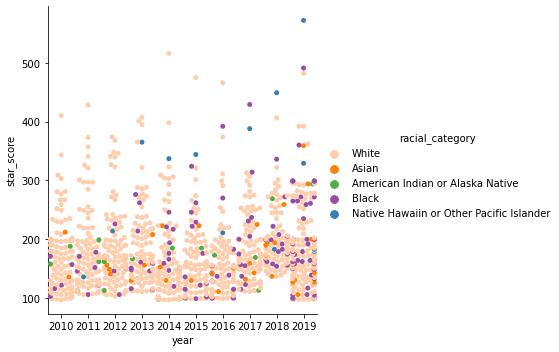

In [225]:
#import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

#Create a catplot that showcases the star scores for all celebrities since 2010
sns.catplot(x="year", y="star_score", hue="racial_category", palette=['#fdcdac','#ff7f00','#4daf4a','#984ea3','#377eb8'], kind="swarm", data=decade_df);

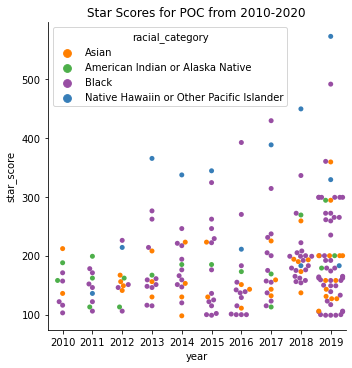

In [250]:
#Create a catplot that shows the Star Score for POC celebrities since 2010 
#This should help convey the info necessary without looking too cluttered
ax = sns.catplot(x='year', y='star_score', hue='racial_category', palette=['#ff7f00','#4daf4a','#984ea3','#377eb8'], kind='swarm', data=decadedf_POC, legend_out=False);
ax.set(title='Star Scores for POC from 2010-2020');

In [248]:
#Remove 2020 data since year is not complete and shows decline for all racial categories
starmeandf_wo2020 = star_mean_df.loc[2010:2019]

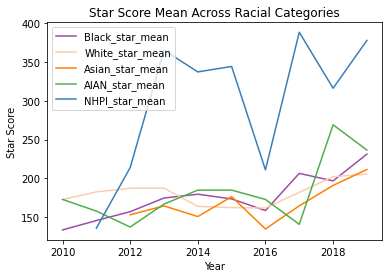

In [243]:
#Create a line plot for the Star Score means for each racial category
ax2 = starmeandf_wo2020.plot(color=['#984ea3','#fdcdac','#ff7f00','#4daf4a','#377eb8'])
ax2.set(title='Star Score Mean Across Racial Categories')
ax2.set_xlabel('Year')
ax2.set_ylabel('Star Score');

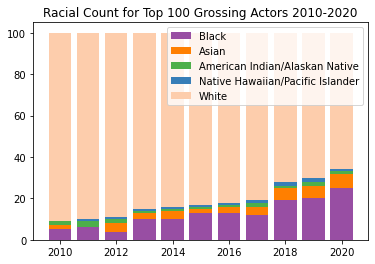

In [186]:
#Create a stacked bar graph to count the number of actors for each racial category

#Set the bottom for each bar graph 
Asian_bottom = Black_counts
AIAN_bottom = np.add(Asian_bottom, Asian_counts)
NHPI_bottom = np.add(AIAN_bottom, AIAN_counts)
White_bottom = np.add(NHPI_bottom, NHPI_counts)

#Create a graph for the number of celebrities in each racial category
plt.bar(years, race_count_df['Black_count'], color='#984ea3')
plt.bar(years, race_count_df['Asian_count'], color='#ff7f00', bottom=Black_counts)
plt.bar(years, race_count_df['AIAN_count'], color='#4daf4a', bottom=np.add(Black_counts, Asian_counts))
plt.bar(years, race_count_df['NHPI_count'], color='#377eb8', bottom=NHPI_bottom)
plt.bar(years, race_count_df['White_count'], color='#fdcdac', bottom=White_bottom)
plt.legend(['Black', 'Asian', 'American Indian/Alaskan Native', 'Native Hawaiian/Pacific Islander', 'White'])
plt.title('Racial Count for Top 100 Grossing Actors 2010-2020');

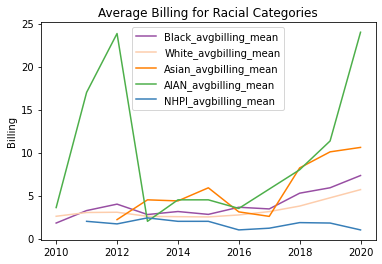

In [226]:
#Create a lineplot that chowcases the Average Billing for each racial category
ax3 = star_avgbilling_df.plot(color=['#984ea3','#fdcdac','#ff7f00','#4daf4a','#377eb8'])
ax3.set(title='Average Billing for Racial Categories', ylabel='Billing');